In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
base_path = './drive/My Drive/Colab Notebooks/Speech Denoising/Data/'

In [3]:
!pip install librosa

In [0]:
import librosa

In [0]:
import math
from time import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [0]:
s, sr=librosa.load(base_path + 'train_clean_male.wav', sr=None)
train_clean=librosa.stft(s, n_fft=1024, hop_length=512).T

sn, sr=librosa.load(base_path + 'train_dirty_male.wav', sr=None)
train_dirty=librosa.stft(sn, n_fft=1024, hop_length=512).T

In [8]:
train_clean.shape, train_dirty.shape

((2459, 513), (2459, 513))

### Take magnitudes of audio signals

In [0]:
train_clean_val = np.abs(train_clean)
train_dirty_val = np.abs(train_dirty)

Check bounds of absolute values

In [10]:
print(f'min(train_clean_val) = {np.min(train_clean_val)}, max(train_clean_val) = {np.max(train_clean_val)}')
print(f'min(train_dirty_val) = {np.min(train_dirty_val)}, max(train_dirty_val) = {np.max(train_dirty_val)}')

min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992


## Training

### Split the data into training and validation set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_dirty_val, train_clean_val, test_size=0.2, shuffle=False)

In [12]:
X_train.shape, X_test.shape

((1967, 513), (492, 513))

### Define tensorflow variables for the model


In [0]:
IMAGE_HEIGHT = 20
IMAGE_WIDTH = X_train.shape[1]

In [14]:
X = tf.placeholder(dtype='float', shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 1])
Y = tf.placeholder(dtype='float', shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

dropout_X = tf.layers.Dropout(rate=0.4)(X)

conv_1 = tf.layers.Conv2D(filters=8, kernel_size=(5, 5), strides=(3, 3), padding='same', data_format='channels_last', activation=tf.nn.relu)(dropout_X)
pool_1 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(conv_1)
bn_1 = tf.layers.BatchNormalization()(pool_1)

dropout_1 = tf.layers.Dropout(rate=0.4)(bn_1)

# conv_2 = tf.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', data_format='channels_last', activation=tf.nn.relu)(dropout_1)
# pool_2 = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# bn_2 = tf.layers.BatchNormalization()(pool_2)

# dropout_2 = tf.layers.Dropout(rate=0.2)(bn_2)

flattened = tf.layers.Flatten()(dropout_1)
dense_1 = tf.layers.Dense(units=IMAGE_HEIGHT * IMAGE_WIDTH, activation=tf.nn.relu)(flattened)
output = tf.reshape(dense_1, shape=[-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1])

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
for layer in [X, dropout_X, conv_1, pool_1, bn_1, dropout_1, flattened, dense_1, output]:
  print('{:100} ? * {:d}'.format(str(layer), np.prod([x.value for x in layer.shape[1:]])))

Tensor("Placeholder:0", shape=(?, 20, 513, 1), dtype=float32)                                        ? * 10260
Tensor("dropout/Identity:0", shape=(?, 20, 513, 1), dtype=float32)                                   ? * 10260
Tensor("conv2d/Relu:0", shape=(?, 7, 171, 8), dtype=float32)                                         ? * 9576
Tensor("max_pooling2d/MaxPool:0", shape=(?, 6, 170, 8), dtype=float32)                               ? * 8160
Tensor("batch_normalization/FusedBatchNorm:0", shape=(?, 6, 170, 8), dtype=float32)                  ? * 8160
Tensor("dropout_1/Identity:0", shape=(?, 6, 170, 8), dtype=float32)                                  ? * 8160
Tensor("flatten/Reshape:0", shape=(?, 8160), dtype=float32)                                          ? * 8160
Tensor("dense/Relu:0", shape=(?, 10260), dtype=float32)                                              ? * 10260
Tensor("Reshape:0", shape=(?, 20, 513, 1), dtype=float32)                                            ? * 10260


In [16]:
learning_rate = 0.0004

loss = tf.losses.mean_squared_error(labels=Y, predictions=output)
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=loss)
init = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


In [0]:
batch_size = 512
num_epochs = 500
display_step = 100
log_step = 100

total_samples_train = X_train.shape[0] - IMAGE_HEIGHT
total_samples_test = X_test.shape[0] - IMAGE_HEIGHT
num_batches_train = int(math.ceil(total_samples_train/batch_size))
num_batches_test = int(math.ceil(total_samples_test/batch_size))

train_loss = []
test_loss = []

In [18]:
st = time()

sess = tf.Session()

sess.run(init)
for epoch in range(1, num_epochs + 1):
  for itr in range(num_batches_train):
    start_idx = itr * batch_size
    end_idx = min((itr + 1) * batch_size, total_samples_train)
    
    # as is
    batch_x = np.array([X_train[i:i + IMAGE_HEIGHT] for i in range(start_idx, end_idx)]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    batch_y = np.array([y_train[i:i + IMAGE_HEIGHT] for i in range(start_idx, end_idx)]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    sess.run(train, feed_dict={X:batch_x, Y:batch_y})
    
    # filp vertically
#     batch_x_v_flip = np.array([p[::-1] for p in batch_x])
#     batch_y_v_flip = np.array([p[::-1] for p in batch_y])
#     sess.run(train, feed_dict={X:batch_x_v_flip, Y:batch_y_v_flip})
    
#     # flip horizontally
#     batch_x_h_flip = np.array([p[::-1] for q in batch_x for p in q]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
#     batch_y_h_flip = np.array([p[::-1] for q in batch_y for p in q]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
#     sess.run(train, feed_dict={X:batch_x_h_flip, Y:batch_y_h_flip})
    
#     # flip vertically and horizontally
#     batch_x_hv_flip = np.array([p[::-1] for p in batch_x_h_flip])
#     batch_y_hv_flip = np.array([p[::-1] for p in batch_y_h_flip])
#     sess.run(train, feed_dict={X:batch_x_hv_flip, Y:batch_y_hv_flip})
    
  if epoch % log_step == 0:
    # calculate loss for entire training and testing set
    trls = 0
    for itr in range(num_batches_train):
      start_idx = itr * batch_size
      end_idx = min((itr + 1) * batch_size, total_samples_train)
      
      batch_x = np.array([X_train[i:i + IMAGE_HEIGHT] for i in range(start_idx, end_idx)]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
      batch_y = np.array([y_train[i:i + IMAGE_HEIGHT] for i in range(start_idx, end_idx)]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
      
      trls += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
      
    tsls = 0
    for itr in range(num_batches_test):
      start_idx = itr * batch_size
      end_idx = min((itr + 1) * batch_size, total_samples_test)

      batch_x = np.array([X_test[i:i + IMAGE_HEIGHT] for i in range(start_idx, end_idx)]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
      batch_y = np.array([y_test[i:i + IMAGE_HEIGHT] for i in range(start_idx, end_idx)]).reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
      
      tsls += sess.run(loss, feed_dict={X:batch_x, Y:batch_y})
    
    # average loss
    trls /= total_samples_train
    tsls /= total_samples_test
    
    train_loss.append(trls)
    test_loss.append(tsls)
    
  if epoch % display_step == 0:
    print(f'Finished epoch:{epoch}')
    print(f'Train set:\tLoss:{trls:.8f}')
    print(f'Test set:\tLoss:{tsls:.8f}\n')
    
print('Time taken: ', (time() - st), 'sec')
print('Time per epoch: ', (time() - st)/num_epochs, 'sec')

Finished epoch:100
Train set:	Loss:0.00002248
Test set:	Loss:0.00011091

Finished epoch:200
Train set:	Loss:0.00001588
Test set:	Loss:0.00011028

Finished epoch:300
Train set:	Loss:0.00001427
Test set:	Loss:0.00011158

Finished epoch:400
Train set:	Loss:0.00001366
Test set:	Loss:0.00011168

Finished epoch:500
Train set:	Loss:0.00001317
Test set:	Loss:0.00011226

Time taken:  330.39452958106995 sec
Time per epoch:  0.6607902011871338 sec


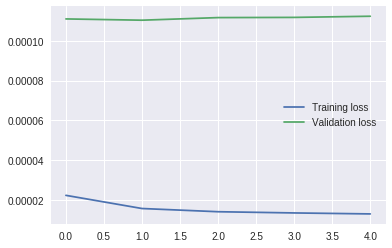

In [19]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['Training loss', 'Validation loss'])

## Prediction

In [0]:
def parse_audio_file(filename):
  # load audio file
  s, sr = librosa.load(filename, sr=None)

  # apply short time fourier transform
  dirty = librosa.stft(s, n_fft=1024, hop_length=512).T

  # take magnitudes of audio signals
  dirty_val = np.abs(dirty)

  return dirty, dirty_val
  
def clean_audio(dirty_val):    
    total_samples = dirty_val.shape[0]
    num_batches = int(math.ceil(total_samples/IMAGE_HEIGHT))
    
    # run it through the neural network to remove noisy bits
    clean_val = np.empty(shape=(0, IMAGE_WIDTH), dtype='float')
    for itr in range(num_batches):
      start_idx = itr * IMAGE_HEIGHT
      end_idx = (itr + 1) * IMAGE_HEIGHT
      
      if end_idx > total_samples:
        # this iteration does not have enough rows to make full image
        op = np.random.random(size=(total_samples - start_idx, IMAGE_WIDTH)) * 0.001
      else:
        batch_x = dirty_val[start_idx:end_idx].reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
        batch_y = dirty_val[start_idx:end_idx].reshape(-1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
        op = sess.run(output, feed_dict={X:batch_x, Y:batch_y})
        op = op.reshape(-1, IMAGE_WIDTH)
        
      clean_val = np.concatenate([clean_val, op], axis=0)
      
    return clean_val
    
def save_as_audio(dirty, dirty_val, clean_val, to_filename):
  # recover speech spectogram of the cleaned signal
  cleaned = np.multiply(np.divide(dirty.T, dirty_val.T), clean_val.T)
  
  # recover time domain speech signal by applying inverse short time fourier transform
  sh_test = librosa.istft(cleaned, hop_length=512)

  # Save to a file
  librosa.output.write_wav(to_filename, sh_test, sr)
  print('Saved to ', to_filename)

In [0]:
def save_cleaned(input_filename, save_filename):
  dirty, dirty_val = parse_audio_file(input_filename)
  clean_val = clean_audio(dirty_val)
  save_as_audio(dirty, dirty_val, clean_val, save_filename)

### Calculate Signal-to-Noise Ratio using following formula

<img src="https://d1b10bmlvqabco.cloudfront.net/attach/jqcgj7tyoxz6oi/jl5gazm4ih22q1/jrx4uo8px5hd/SNR.JPG" width="400">


In [0]:
def snr(dirty, clean):
  clean_val = clean_audio(dirty)
  return 10 * np.log10(np.sum(np.square(clean))/np.sum(np.square(clean - clean_val)))

#### SNR for training data

In [23]:
snr(clean_audio(X_train), y_train)

7.9824129054365365

#### SNR for validation data

In [24]:
snr(clean_audio(X_test), y_test)

2.3019775850783826

In [25]:
save_cleaned(base_path + 'test_x_01.wav', base_path + 'test_x_01_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_01_cleaned.wav


In [26]:
save_cleaned(base_path + 'test_x_02.wav', base_path + 'test_x_02_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/test_x_02_cleaned.wav


In [27]:
save_cleaned(base_path + 'train_dirty_male.wav', base_path + 'train_dirty_male_cleaned.wav')

Saved to  ./drive/My Drive/Colab Notebooks/Speech Denoising/Data/train_dirty_male_cleaned.wav


In [0]:
# sess.close()